<a href="https://colab.research.google.com/github/carneiro-fernando/EBAC/blob/main/Projetos/Projeto_de_Parceria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div style="align-items: center; justify-content: space-between;">
   <img src="https://raw.githubusercontent.com/carneiro-fernando/EBAC/e9ee8a6e1101b0b0ebd61253b91f146b0931ad63/assets/Images/Projeto_parceria/Semantix_Logo.JPG"  align="right" alt="Semantix-logo" width="12%">

   <h1>Regressão Linear para predições no Mercado Financeiro</h1>
   <b> por <a href="https://www.linkedin.com/in/fernandohcarneiro/">Fernando Carneiro</a> </b>
   
   ## Sumário
   1.   [**Introdução**](#intro)
   1.   [**Análise de Dados**](#da)
   1.   [**Aprendizado de Máquina**](#ml)
   1.   [**Resultados**](#results)
   1.   [**Conclusão**](#conclusion)
</div>

---

<a id='intro'></a>
## 1. Introdução

### 1.1 Objetivo
O objetivo deste projeto é realizar uma análise de dados exploratória e demonstrar a eficácia da Regressão Linear, uma técnica básica de aprendizado de máquina, na previsão do valor de ações.

### 1.2 Descrição dos dados
Utilizei neste projeto dados obtidos do site [Yahoo Finance](https://finance.yahoo.com) através da API **yFinance**, disponível [aqui](https://pypi.org/project/yfinance/), ela permite a coleta de forma fácil aos dados financeiros do site e por ser uma biblioteca de código aberto, é amplamente usada na comunidade de análise financeira como ferramenta confiável. A análise se concentra em empresas selecionadas do setor de saúde que estão listadas na bolsa de valores, ela inclui empresas que oferecem planos de saúde e redes de hospitais. Abaixo segue uma tabela com as empresas que serão analisadas durante este projeto. Na tabela o termo "*ticker*" refere-se a um código alfanumérico que identifica uma ação.

| Empresa | Ticker | Ramo | Website |
| --- | --- |--- | --- |
| Kora Saúde Participações S.A. | KRSA3 | Rede de hospitais | [Link](https://www.korasaude.com.br) |
| Hospital Mater Dei SA | MATD3 | Rede de hospitais | [Link](https://www.materdei.com.br) |
| Oncoclinicas do Brasil Servicos Medicos SA | ONCO3 | Rede de hospitais | [Link](https://www.grupooncoclinicas.com) |
| Rede D'Or São Luiz S.A. | RDOR3 | Rede de hospitais | [Link](https://ri.redeor.com.br) |
| Hapvida Participações e Investimentos S.A. | HAPV3 | Planos de saúde | [Link](https://www.hapvida.com.br) |
| Odontoprev S.A. | ODPV3 | Planos de saúde | [Link](https://www.odontoprev.com.br) |
| Qualicorp S.A. | QUAL3 | Planos de saúde | [Link](https://www.qualicorp.com.br) |
| Diagnósticos da América S.A. | DASA3 | Planos de saúde e rede de hospitais | [Link](https://www.dasa3.com.br) |

### 1.3 Estrutura dos dados (*schema*)
Os dados que trabalharemos tem a seguinte estrutura:

| Termo | Descrição | Tipo de dado |
| --- | --- | --- |
|'Date' | A data do registro de preço | DateTimeIndex
| 'Open' | O preço de abertura da ação no período | numpy.float64 |
| 'High' | O preço mais alto alcançado pela ação no período | numpy.float64 |
| 'Low' | O preço mais baixo alcançado pela ação no período | numpy.float64 |
| 'Close' | O preço de fechamento da ação no período | numpy.float64 |
| 'Volume' | O volume de negociação da ação no período | numpy.float64 |

### 1.4 Bibliotecas
Uma breve descrição das bibliotecas que foram usadas no projeto:

- **Pandas**: Uma biblioteca de manipulação e análise de dados que fornece estruturas de dados flexíveis e permite trabalhar com dados estruturados ou tabulares de maneira fácil e intuitiva.

- **NumPy**: Uma biblioteca para a linguagem Python, com suporte a arrays e matrizes multidimensionais, possuindo uma larga coleção de funções matemáticas para trabalhar com estas estruturas.

- **Matplotlib**: Uma biblioteca para criação de gráficos e visualizações de dados em geral, mais usada para gráficos 2D de arrays.

- **Seaborn**: Baseado em Matplotlib, o Seaborn ajuda na criação de gráficos mais atraentes e informativos. Ele é especialmente útil para visualização de dados estatísticos.

- **Scikit-learn**: Uma das bibliotecas mais populares para aprendizado de máquina em Python. Ela inclui vários algoritmos de classificação, regressão e agrupamento, incluindo máquinas de vetores de suporte, florestas aleatórias, gradient boosting, k-means e DBSCAN.

- **yFinance**: Uma biblioteca Python que permite baixar dados históricos do mercado de ações do Yahoo Finance.

In [29]:
# Importações da bibliotecas
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

---
<a id='da'></a>
## 2. Análise de Dados

### 2.1 Coleta de dados

#### A seguir as empresas do ramo de saúde listadas na B3

In [30]:
# Ignora warnings
warnings.filterwarnings('ignore')

# Este breve trecho de código nos ajuda a visualizar melhor os dados no notebook por filtrar avisos desnecessários.

In [31]:
# Listando os ativos de saúde
nomes_dos_tickers = ["KRSA3.SA", "MATD3.SA", "ONCO3.SA", "RDOR3.SA", "HAPV3.SA", "ODPV3.SA", "QUAL3.SA", "DASA3.SA"]

# Criando DataFrames com os dados históricos para todos os ativos
ticks_df = yf.download(nomes_dos_tickers, period='max', rounding=True, auto_adjust=True)

# Verificando o DataFrame
ticks_df.tail(5)

# A documentação do método .download() pode ser encontrada no link a seguir: (https://github.com/ranaroussi/yfinance/wiki/tickers#download)

[******************    38%%                      ]  3 of 8 completed

[*********************100%%**********************]  8 of 8 completed


Close                                                        \
           DASA3.SA HAPV3.SA KRSA3.SA MATD3.SA ODPV3.SA ONCO3.SA QUAL3.SA   
Date                                                                        
2023-11-20    10.29     4.64     0.98     7.61    11.50     9.99     3.06   
2023-11-21     9.64     4.65     0.98     7.57    11.36     9.80     2.94   
2023-11-22     9.55     4.56     1.04     7.47    10.94     9.66     2.84   
2023-11-23     9.64     4.50     1.00     7.51    10.96     9.90     2.89   
2023-11-24     9.56     4.50     1.00     7.32    10.93     9.85     2.79   

                        High           ...     Open            Volume  \
           RDOR3.SA DASA3.SA HAPV3.SA  ... QUAL3.SA RDOR3.SA DASA3.SA   
Date                                   ...                              
2023-11-20    25.99    10.31     4.68  ...     3.10    25.21   227600   
2023-11-21    25.62    10.29     4.66  ...     3.06    25.99   488200   
2023-11-22    25.86     9.97     4.84  ...     2.97    25.87   487400   
2023-11-23    26.11     9.89     4.62  ...     2.85    25.98   139800   
2023-11-24    25.99     9.73     4.56  ...     2.90    25.87   307900   

                                                                               \
               HAPV3.SA  KRSA3.SA  MATD3.SA   ODPV3.SA   ONCO3.SA    QUAL3.SA   
Date                                                                            
2023-11-20   51808800.0  372500.0  313700.0   553300.0  3250900.0   5801600.0   
2023-11-21   52522200.0  469700.0  207300.0   945400.0  1515700.0   6244700.0   
2023-11-22  114011500.0  758400.0  285500.0  1017400.0  2274900.0  10503700.0   
2023-11-23   27375400.0  361600.0  121900.0   690200.0  1351600.0   5593100.0   
2023-11-24   23074400.0  285000.0  128400.0   511200.0   537600.0   4533700.0   

                       
             RDOR3.SA  
Date                   
2023-11-20  4017100.0  
2023-11-21  3428900.0  
2023-11-22  3933200.0  
2023-11-23  2018300.0  
2023-11-24  1315000.0  

[5 rows x 40 columns]

### 2.2 Limpeza dos dados

A primeira etapa da limpeza de dados foi verificar quantos valores nulos havia em cada coluna do DataFrame ticks_df. Isso é útil para a limpeza de dados, pois os valores nulos podem precisar ser tratados antes da análise.

In [32]:
# Verifica o número de valores nulos em cada coluna do DataFrame
print(ticks_df.isna().sum())

Close   DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
High    DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
Low     DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
Open    DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
Volume  DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998


A análise das séries de dados dos tickers analisados revelou a presença de milhares de valores nulos, com exceção do ticker DASA3.SA. Essa diferença é explicada pelas diferentes datas de início de registro na bolsa de valores das empresas analisadas. A DASA, por exemplo, foi a primeira empresa a iniciar suas negociações na bolsa dentre as empresas analisadas. A próxima etapa da análise consiste em verificar as datas iniciais de registro na bolsa de valores de cada empresa.

In [33]:
# Criando um DataFrame com a data da primeira operação registrada no objeto inicializado da API yFinance
data_inicial_df = pd.DataFrame({'Data_inicial': [yf.Ticker(t).history_metadata['firstTradeDate'] for t in nomes_dos_tickers]}, index=nomes_dos_tickers)

# Convertendo o formato de data
data_inicial_df['Data_inicial'] = (pd.to_datetime(data_inicial_df['Data_inicial'], unit='s').dt.date)

# Verificando
data_inicial_df.sort_values(by='Data_inicial')

,Data_inicial
DASA3.SA,2004-11-19
ODPV3.SA,2006-12-01
QUAL3.SA,2011-06-29
HAPV3.SA,2018-04-26
RDOR3.SA,2020-12-15
MATD3.SA,2021-05-13
KRSA3.SA,2021-08-16
ONCO3.SA,2021-09-21


Com essa informação em mãos, cada ticker foi examinado em busca de valores nulos após a data de registro inicial. O resultado (abaixo) mostra que durante o período de registro os dados são integrais, sem necessidade de intervenção adicional.

In [34]:
# Verificando se há valores inválidos durante o período de registro de transações para cada ticker.
print('Valores nulos desde o início do registro:\n')

for ticker in data_inicial_df.index:
  data_inicial = data_inicial_df.loc[ticker, 'Data_inicial']

  # Selecionando dentro do índice 'Close' as datas entre o período inicial e o último registro.
  periodo_selecionado = ticks_df['Close'][ticker].loc[data_inicial : ]

  # Imprimindo a soma de valores nulos dentro do período selecionado.
  print(f"Nome: {ticker} | data inicial: {data_inicial} | valores nulos: {periodo_selecionado.isnull().sum()}")

Valores nulos desde o início do registro:

Nome: KRSA3.SA | data inicial: 2021-08-16 | valores nulos: 0
Nome: MATD3.SA | data inicial: 2021-05-13 | valores nulos: 0
Nome: ONCO3.SA | data inicial: 2021-09-21 | valores nulos: 0
Nome: RDOR3.SA | data inicial: 2020-12-15 | valores nulos: 0
Nome: HAPV3.SA | data inicial: 2018-04-26 | valores nulos: 0
Nome: ODPV3.SA | data inicial: 2006-12-01 | valores nulos: 0
Nome: QUAL3.SA | data inicial: 2011-06-29 | valores nulos: 0
Nome: DASA3.SA | data inicial: 2004-11-19 | valores nulos: 0


### Visualização dos dados

A análise dos dados numéricos do DataFrame, explora padrões, tendências e ajuda a identificar *outliers*. Para tal, o método describe() faz uma análise suficientemente completa.

In [35]:
# Análise dos dados numéricos. Como referencia foi usado o índice 'Close'.
ticks_df['Close'].describe()

,DASA3.SA,HAPV3.SA,KRSA3.SA,MATD3.SA,ODPV3.SA,ONCO3.SA,QUAL3.SA,RDOR3.SA
count,4730.000000,1385.000000,569.000000,634.000000,4211.000000,544.000000,3082.000000,732.000000
mean,20.207421,9.020754,2.755641,11.431672,8.076227,8.797904,15.585652,42.859740
std,20.838805,4.032525,1.985351,3.894417,3.902377,2.338656,7.308379,16.734414
min,4.660000,1.940000,0.740000,6.110000,1.080000,4.210000,2.790000,19.840000
25%,9.640000,5.406500,1.050000,8.285000,5.680000,6.802500,10.752500,28.927500
50%,12.860000,8.177300,2.540000,9.690000,7.970000,9.030000,13.742550,34.415000
75%,24.610000,12.406400,3.550000,15.230000,11.480000,10.612500,19.248725,62.205000
max,195.840000,18.151400,8.150000,21.220000,16.090000,15.410000,39.847300,73.300000


A partir da análise, podemos extrair os seguintes *insights*:

*   DASA3.SA - É a ação negociada a mais tempo com +4700 registros (count), confirmando os dados que temos sobre data inicial.

*   RDOR3.SA - Tem o maior valor médio, mais que o dobro da segunda ação com maior valor.

*   KRSA3.SA - Tem o menor média e desvio padrão em termos de valor financeiro, em contraste DASA3.SA tem a maior volatilidade com desvio padrão de ~R$20,00.

*   *Outliers* - A ação DASA3.SA tem uma diferença muito grande entre o terceiro quartil e o valor máximo, indicando possíveis '*outliers*'.

Abaixo foi realizada a visualização exploratória dos dados históricos dos ativos através da plotagem de gráficos de séries temporais. Os gráficos de séries temporais são ferramentas poderosas para a análise de dados financeiros. A fim de simplificar o entendimento e manter a concisão do projeto, foram usados gráficos de linha ao invés de gráficos de *candle sticks*. Abaixo, os gráficos de todo os histórico de registro de preços de cada *ticker*, note que o intervalo de tempo de cada gráfico é diferente.

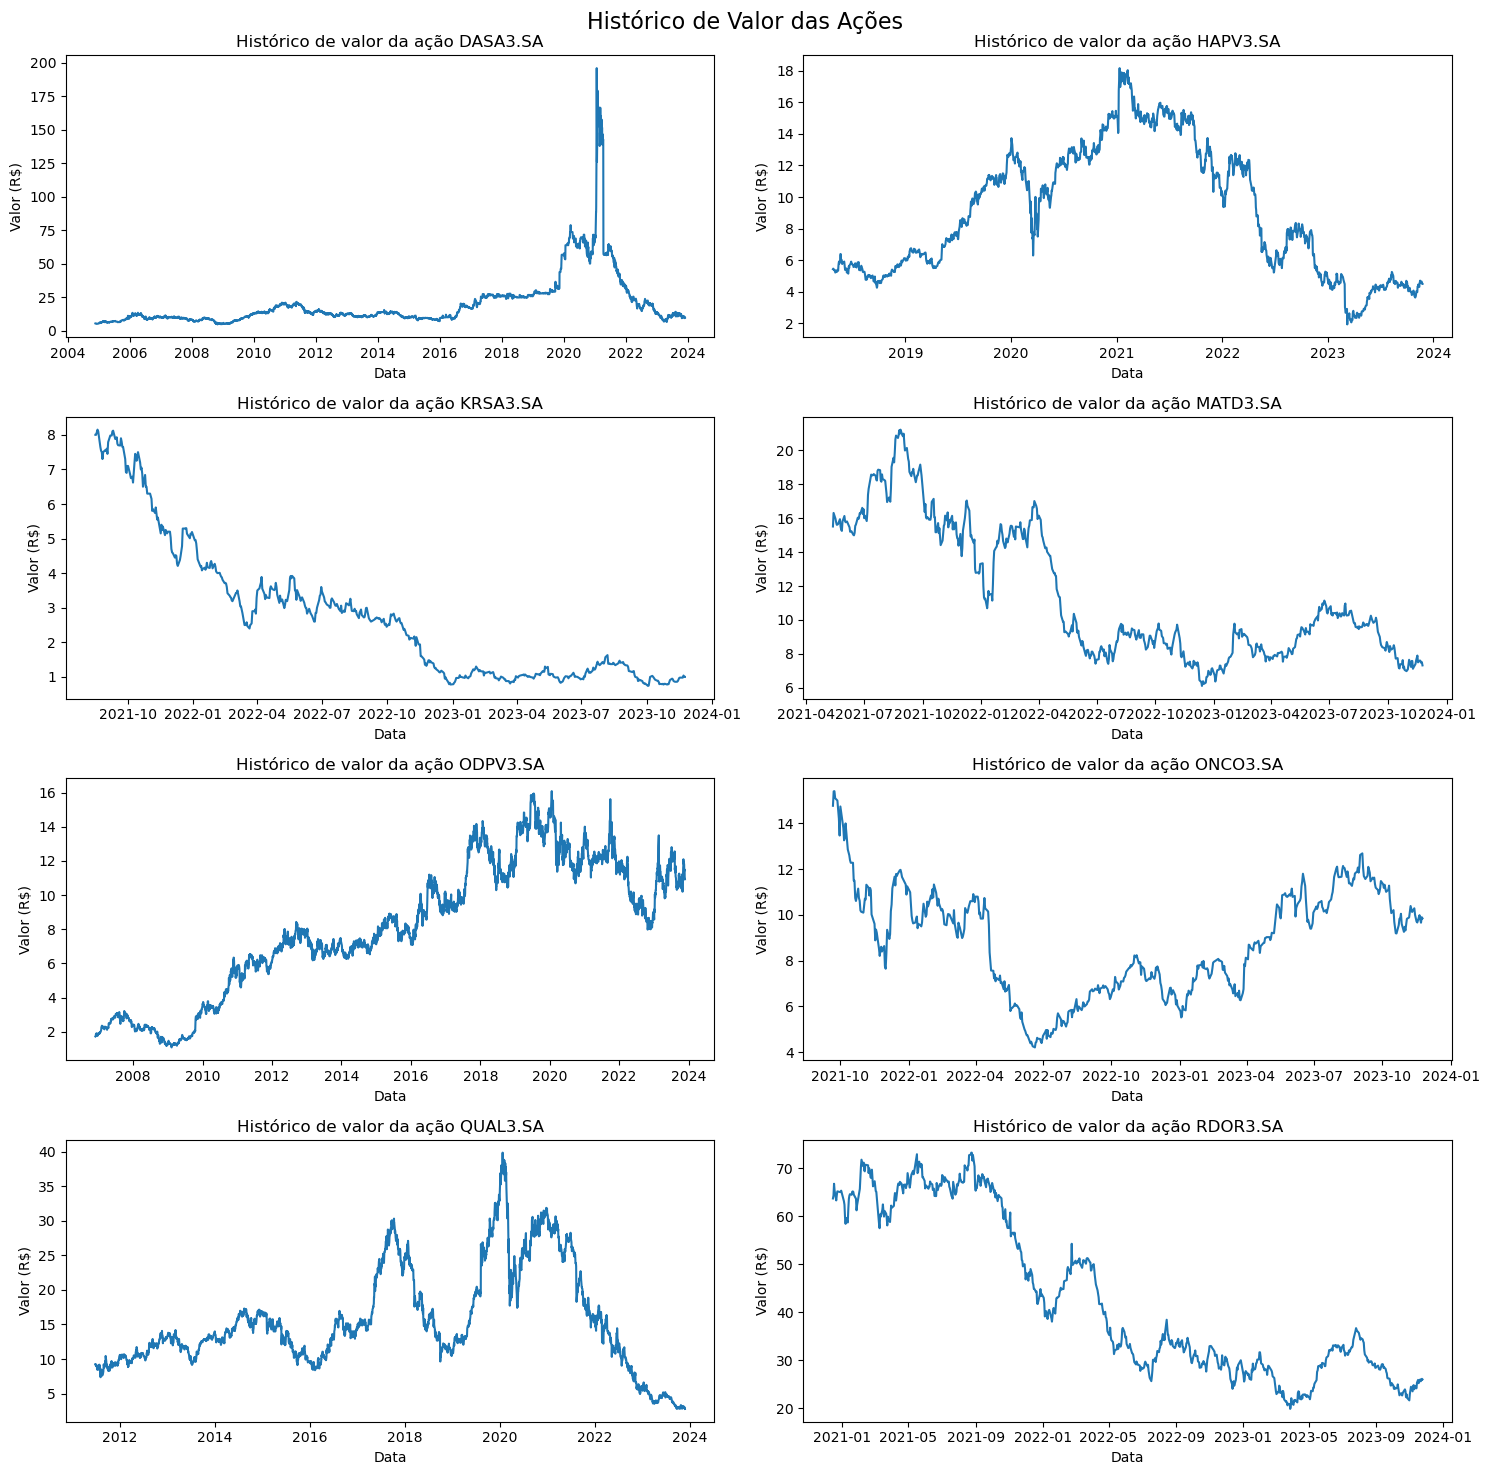

In [36]:
# Criando um grid de gráficos
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
fig.suptitle("Histórico de Valor das Ações", fontsize=16)

# Laço de repetição que cria os gráficos
for (nome, dados), ax in zip(ticks_df['Close'].items(), axes.ravel()):
    sns.lineplot(x=dados.index, y=dados.values, ax=ax)
    ax.set_title(f'Histórico de valor da ação {nome}')
    ax.set_ylabel('Valor (R$)')
    ax.set_xlabel('Data')

# Ajuste e visualização
plt.tight_layout()
plt.show()

A partir da análise, podemos extrair os seguintes *insights*:

* Os *tickers* com abertura anterior ao período de pandemia (2020-2022) experimentaram uma tendência de alta por muito tempo, como fica bem claro no gráfico da Odontoprev (ODPV3.SA)

* Das empresas analisadas,  metade abriu seu capital na bolsa de valores durante o período de pandemia em meados de 2021.

* Houve uma alta muito forte durante o período de pandemia seguido de uma reversão, após isso houve uma tendência de baixa (*bear market*) para alguns *tickers* e lateralização para outros. Isso é uma indicação óbvia de que a alta demanda do setor de saúde durante a pandemia resultou numa supervalorização dos ativos que depois foi normalizada.

* O *ticker* DASA3 durante o ano de 2021 teve uma movimentação muito parecida com a prática '*pump and dump*' que compreende em uma prática onde há um aumento repentino e significativo no preço do ativo, muitas vezes impulsionado por informações enganosas, seguido de uma queda rápida nos preços, muitas vezes devolvendo o ativo ao seu valor original ou até abaixo.

Para fins de comparação, foi selecionado um intervalo de tempo em comum, ou seja, em que haja dados disponíveis para todas as empresas. O algoritmo abaixo visa identificar a data que seja comum à todos os ativos analisados, que o ativo com data de primeiro registro mais recente.

In [37]:
# Criando a variável que conterá a data mais recente
data_mais_recente = datetime.date

# Reduzindo a dimensão do DataFrame (transformando o índice de operação em coluna)
unstacked_ticks_df = ticks_df.stack(level=0).rename_axis(['Date', 'Operation'])

# Excluindo todas as linhas com dados não numéricos (NaN) nós chegamos à primeira data comum a todos os ativos
data_mais_recente = unstacked_ticks_df.dropna().index[0][0]

# Verificando
print(f"A data mais recente dentre o primeiro registro dos DataFrames é: {data_mais_recente.date()}")

A data mais recente dentre o primeiro registro dos DataFrames é: 2021-09-21


A seguir, foi selecionado o período entre 21 de Setembro de 2021 e a data de hoje (ou a última disponível) e verificado o tamanhos das séries.

In [38]:
# Selecionando o período encontrado previamente
ticks_2021_df = ticks_df.loc[data_mais_recente:]

# Conferindo se todos os DataFrames tem o mesmo número de linhas
print({key: df.shape[0] for key, df in ticks_2021_df['Close'].items()})

{'DASA3.SA': 544, 'HAPV3.SA': 544, 'KRSA3.SA': 544, 'MATD3.SA': 544, 'ODPV3.SA': 544, 'ONCO3.SA': 544, 'QUAL3.SA': 544, 'RDOR3.SA': 544}


Restringindo os dados a somente os registros de fechamento ('Close'), que iremos efetivamente usar. O fechamento é o valor do ativo 

In [39]:
# Criação de um DataFrame com os valores de fechamento de cada ativo
close_2021_df = pd.DataFrame(ticks_2021_df['Close'], columns= ticks_2021_df['Close'].columns)

# Visualização do DataFrame com os dados de fechamento a partir de 2021 (close_2021_df)
close_2021_df

,DASA3.SA,HAPV3.SA,KRSA3.SA,MATD3.SA,ODPV3.SA,ONCO3.SA,QUAL3.SA,RDOR3.SA
Date,,,,,,,,
2021-09-21,44.96,15.1600,7.90,18.32,13.00,14.77,20.7316,67.67
2021-09-22,45.15,14.5707,7.80,18.51,13.34,15.40,20.3943,67.20
2021-09-23,44.74,14.8703,7.65,18.52,13.33,15.41,20.4232,67.89
2021-09-24,45.61,14.7205,7.65,18.71,14.32,15.10,20.2401,67.40
2021-09-27,44.73,14.4509,7.30,19.16,14.44,15.00,20.1533,66.15
...,...,...,...,...,...,...,...,...
2023-11-20,10.29,4.6400,0.98,7.61,11.50,9.99,3.0600,25.99
2023-11-21,9.64,4.6500,0.98,7.57,11.36,9.80,2.9400,25.62
2023-11-22,9.55,4.5600,1.04,7.47,10.94,9.66,2.8400,25.86


Na visualização dos gráficos de séries temporais abaixo, é possível compreender o comportamento de cada ativo no mesmo intervalo de tempo, tornando-se assim mais apropriada a comparação entre os ativos.

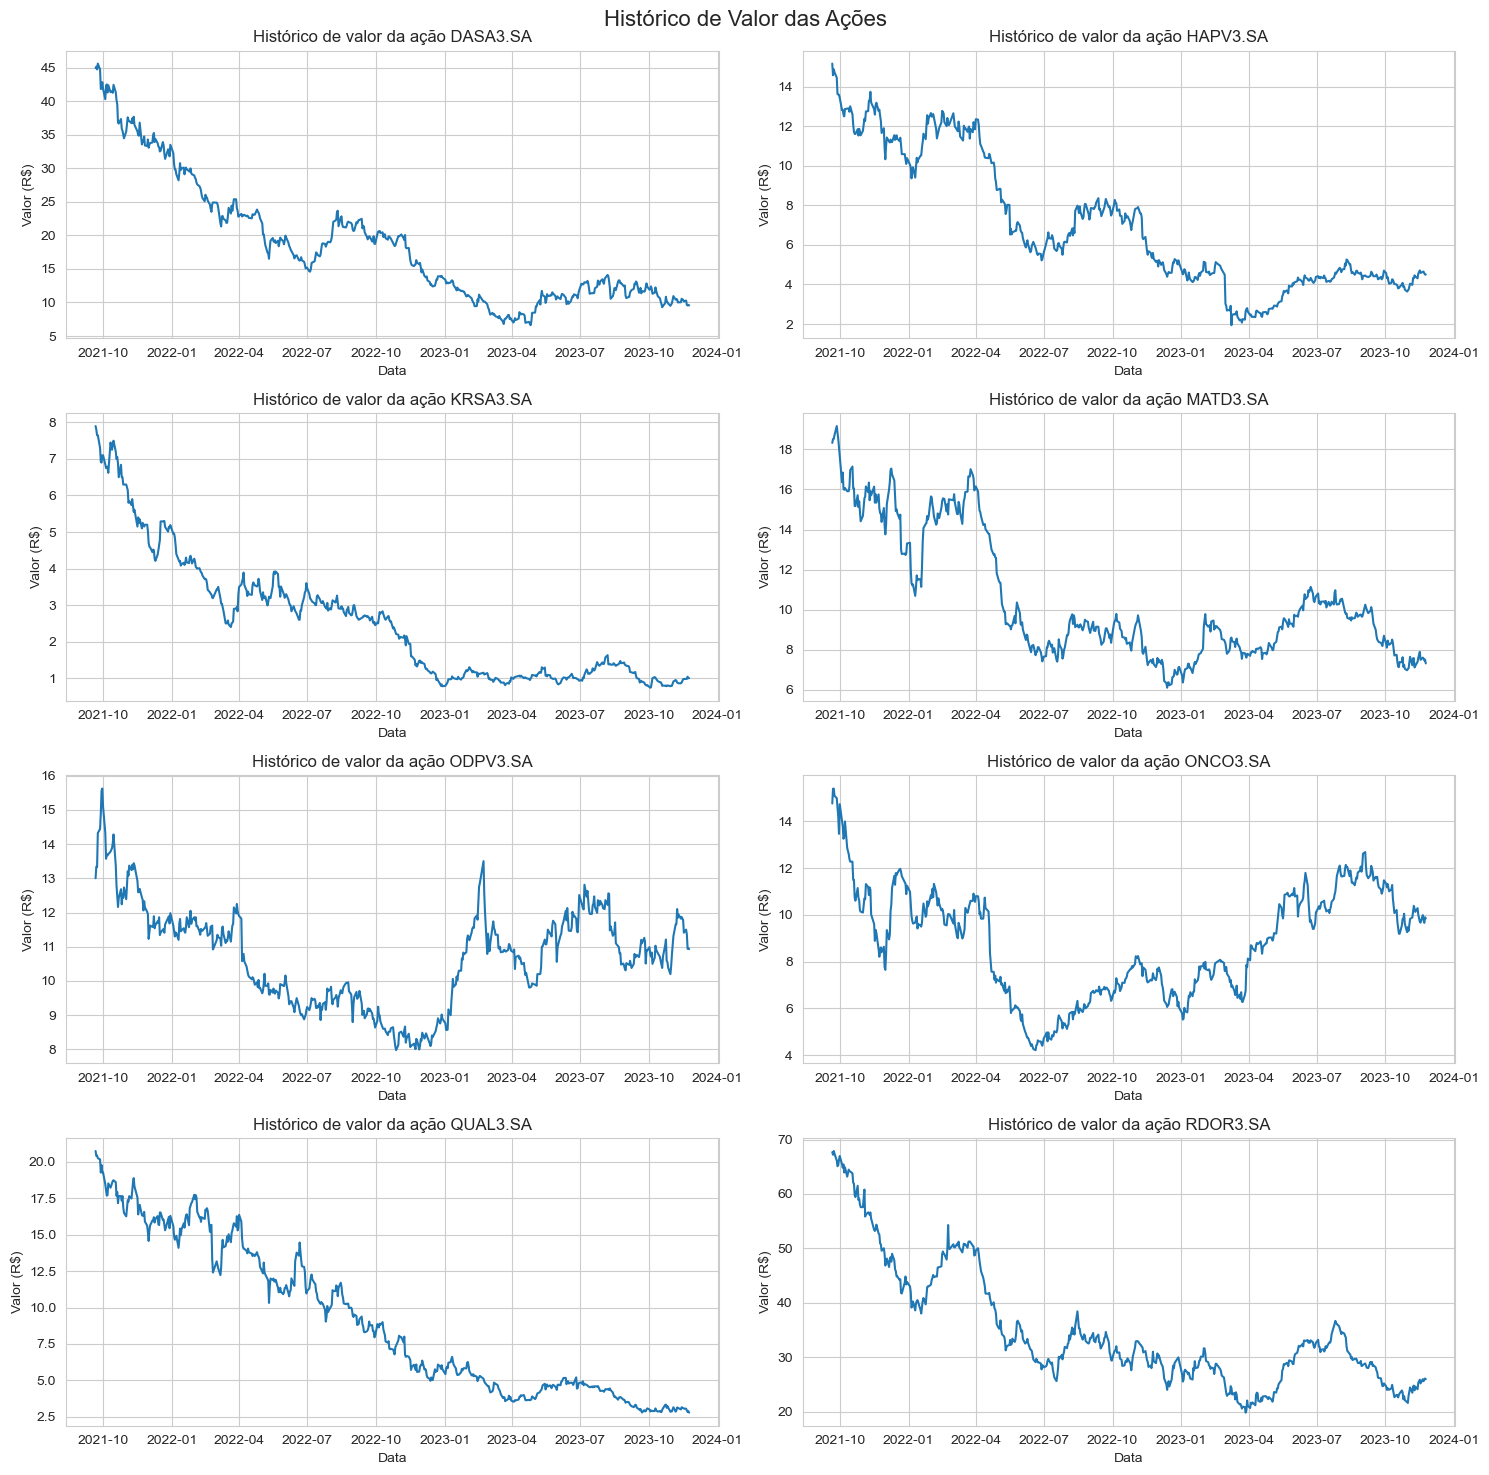

In [40]:
with sns.axes_style(style='whitegrid'):
  fig, axes = plt.subplots(4, 2, figsize=(15, 15))
  fig.suptitle("Histórico de Valor das Ações", fontsize=16)

  # Laço de repetição que cria os gráficos
  for (nome, dados), ax in zip(close_2021_df.items(), axes.ravel()):
      sns.lineplot(x=dados.index, y=dados.values, ax=ax)
      ax.set_title(f'Histórico de valor da ação {nome}')
      ax.set_ylabel('Valor (R$)')
      ax.set_xlabel('Data')

  plt.tight_layout()
  plt.show()

A partir da análise, podemos extrair os seguintes *insights*:

* Apesar se o eixo X (data) dos gráficos compreenderem a mesma dimensão, o eixo Y (valor) não está proporcionalmente igual. Note que entre a maior (RDOR3.SA) máxima e a menor (KRSA3.SA) máxima existe uma diferença de ~875%.

* Os *tickers*, apesar de no momento ainda não terem rompido a mínima observada entre o fim de 2022 e o primeiro trimestre de 2023, estão à longo prazo em uma tendência de queda (*bear market*).

* Foi possível observar que os *tickers* MATD3.SA, ODPV3.SA e ONCO3.SA tem uma volatilidade alta, isso acontece quando há oscilações significativas com constância em um gráfico.

* Foi notado que no mesmo período as empresas tem um comportamento muito similar, indicando uma possível correlação entre elas.

Realizamos uma análise de correlação entre as ações para investigar se existia alguma relação entre elas. Para isso usaremos o coeficiente de correlação de Pearson.

#### Correlação de Pearson
É uma medida estatística que avalia a força e a direção de uma relação linear entre duas variáveis contínuas. Ela é amplamente utilizada em estatística e análise de dados para quantificar o grau de associação entre dois conjuntos de dados. O coeficiente de correlação de Pearson é representado pelo símbolo "r" e varia de -1 a +1.

A fórmula da correlação de Pearson é:

$$ r = \frac{\sum{(X_i - \bar{X})(Y_i - \bar{Y})}}{\sqrt{\sum{(X_i - \bar{X})^2} \sum{(Y_i - \bar{Y})^2}}} $$

Onde:
- $X_i$ e $Y_i$ são os valores individuais das duas variáveis.
- $\bar{X}$ e $\bar{Y}$ são as médias das duas variáveis, respectivamente.

A interpretação do coeficiente de correlação de Pearson é a seguinte:

- $r = 1$: Correlação perfeita positiva (quando uma variável aumenta, a outra também aumenta proporcionalmente).
- $r = -1$: Correlação perfeita negativa (quando uma variável aumenta, a outra diminui proporcionalmente).
- $r = 0$: Ausência de correlação linear.

Apesar de sua ampla aceitação, é importante mencionar que o coeficiente de correlação de Pearson mede apenas relações lineares entre variáveis e é sensível à *outliers*. Ele também não implica causalidade, podendo haver outros fatores que falsamente apontem correlação, requerendo assim interpretação cuidadosa considerando suas limitações.


In [41]:
# Reseta o índice do DataFrame e calcula a correlação de Pearson entre os ativos
close_2021_df = close_2021_df.reset_index()
corr_df = close_2021_df.corr(method='pearson', numeric_only=True)

corr_df

,DASA3.SA,HAPV3.SA,KRSA3.SA,MATD3.SA,ODPV3.SA,ONCO3.SA,QUAL3.SA,RDOR3.SA
DASA3.SA,1.000000,0.934021,0.961334,0.822829,0.390167,0.300124,0.924272,0.912914
HAPV3.SA,0.934021,1.000000,0.880887,0.880600,0.361425,0.296140,0.936256,0.919575
KRSA3.SA,0.961334,0.880887,1.000000,0.772814,0.376923,0.222608,0.931547,0.874102
MATD3.SA,0.822829,0.880600,0.772814,1.000000,0.663622,0.579246,0.812859,0.935664
ODPV3.SA,0.390167,0.361425,0.376923,0.663622,1.000000,0.746321,0.311092,0.575040
ONCO3.SA,0.300124,0.296140,0.222608,0.579246,0.746321,1.000000,0.121815,0.462492
QUAL3.SA,0.924272,0.936256,0.931547,0.812859,0.311092,0.121815,1.000000,0.871495
RDOR3.SA,0.912914,0.919575,0.874102,0.935664,0.575040,0.462492,0.871495,1.000000


A visualização da matriz de correlação temos uma diagonal principal contendo valores 1, pois uma variável está perfeitamente correlacionada consigo mesma. No entanto, para facilitar a compreensão, abaixo foi eliminado a triângulo superior (repetido) e plotado um mapa de calor, que é uma representação gráfica onde as variações nos valores das variáveis são mostradas por meio de cores.

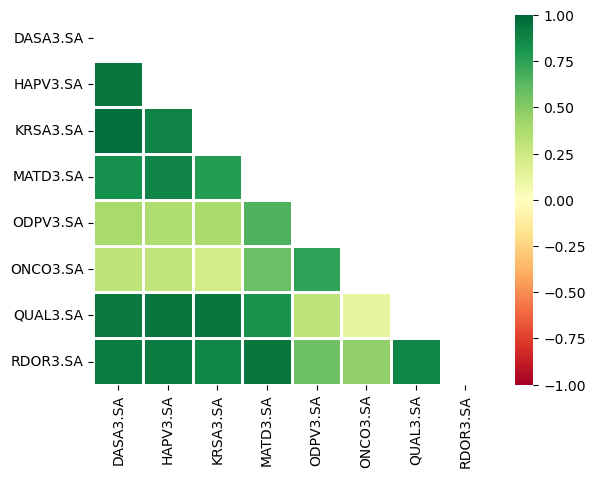

In [42]:
# Criando um numpy array identico (like) a corr_df e preenchido com zeros, ele será usado para eliminar a parte triangular superio da matriz de correlação.
mask = np.zeros_like(corr_df)

# Função do pacote NumPy que dado um array ou matriz (quadrada), seleciona a parte triângular superior.
mask[np.triu_indices_from(mask)] = True

# Gerando gráfico
sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2, annot=True, fmt=".2f")
plt.xticks(rotation=90)
plt.show()

Foi possível notar no mapa de calor que os ativos tem definitivamente não são inversamente proporcionais, tendo alguns um coeficiente de correlação muito próximo de 1 com excessão dos *tickers* ODPV3 e ONCO3.

Os tickers foram divididos em dois setores específicos: Planos de Saúde e Hospitais. Isso foi feito para investigar se a correlação está relacionada ao campo de atuação de cada empresa.

In [43]:
# Criando um DataFrame com os ativos de planos de saúde e hospitais
ticks_plano_saude_df = close_2021_df[['Date', 'HAPV3.SA', 'ODPV3.SA', 'QUAL3.SA', 'DASA3.SA']]
ticks_hospitais_df = close_2021_df[['Date', 'KRSA3.SA', 'MATD3.SA', 'ONCO3.SA', 'RDOR3.SA']]

print('\n DataFrame com Planos de Saúde:')
ticks_plano_saude_df.head(4)



 DataFrame com Planos de Saúde:


,Date,HAPV3.SA,ODPV3.SA,QUAL3.SA,DASA3.SA
0,2021-09-21,15.1600,13.00,20.7316,44.96
1,2021-09-22,14.5707,13.34,20.3943,45.15
2,2021-09-23,14.8703,13.33,20.4232,44.74
3,2021-09-24,14.7205,14.32,20.2401,45.61


In [44]:
print('\n DataFrame com Redes de Hospitais:')
ticks_hospitais_df.head(4)


 DataFrame com Redes de Hospitais:


,Date,KRSA3.SA,MATD3.SA,ONCO3.SA,RDOR3.SA
0,2021-09-21,7.90,18.32,14.77,67.67
1,2021-09-22,7.80,18.51,15.40,67.20
2,2021-09-23,7.65,18.52,15.41,67.89
3,2021-09-24,7.65,18.71,15.10,67.40


Para aprofundar nossa análise, decidi investigar se existia uma correlação dentro do mesmo segmento de atuação. É presumível que empresas que operem no mesmo setor tenham performances similares devido a fatores de mercado compartilhados. Para visualizar essas possíveis correlações de maneira mais intuitiva, optamos por criar outro vez um mapa de calor, sendo agora um para cada segmento.

In [45]:
# Criando DataFrames com dados de correlação
corr_planos_df = ticks_plano_saude_df.corr(method='pearson', numeric_only=True)
corr_hospitais_df = ticks_hospitais_df.corr(method='pearson', numeric_only=True)
corr_planos_df.head().reset_index().columns.name = None
corr_hospitais_df.head().reset_index().columns.name = None

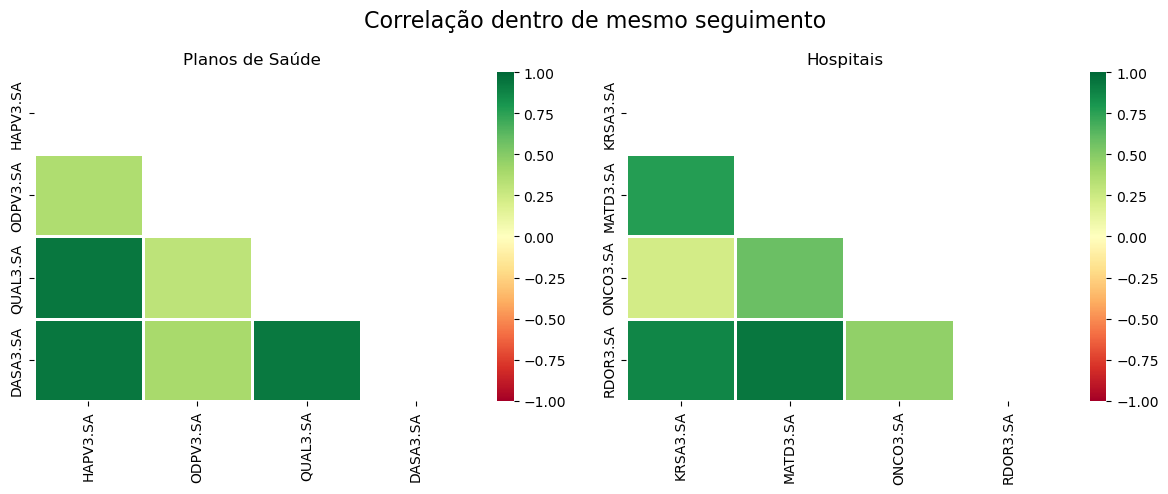

In [46]:
# Criando gráfico de correlação para os planos de saúde e hospitais
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Correlação dentro de mesmo seguimento", fontsize=16)

# Criando um numpy array identico (like) a corr_df e preenchido com zeros
mask_segmentos = np.zeros_like(corr_planos_df)
mask_segmentos[np.triu_indices_from(mask_segmentos)] = True

# Mapa de calor para corr_planos_df
sns.heatmap(corr_planos_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0, mask=mask_segmentos, linewidths=2, annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Planos de Saúde")

# Mapa de calor para corr_hospitais_df
sns.heatmap(corr_hospitais_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0, mask=mask_segmentos, linewidths=2, annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Hospitais")

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()

Este mapa de calor nos permitiu identificar rapidamente que as empresas tem pouco em comum em termos de comportamento, não apresentando nenhuma informação relevante no que diz respeito à sua correlação definida pelo setor de atuação.

Vamos proceder com a análise da correlação com um benchmark conhecido da B3, o Ibovespa. O Ibovespa é o principal indicador de desempenho das ações negociadas na B3 e reflete o comportamento das principais ações listadas na bolsa. Ele é usado como referência para o desempenho do mercado acionário brasileiro. Portanto, verificar a correlação das ações com o Ibovespa nos permitirá entender como elas estão performando em relação ao mercado como um todo.

In [47]:
# Extrai o histórico de preços de fechamento (Close) do IBOVESPA durante o mesmo intervalo de tempo
ibovespa_ticker = yf.Ticker('^BVSP')
ibov_df = ibovespa_ticker.history(start=data_mais_recente)
ibov_df = ibov_df[['Close']]
ibov_df = ibov_df.set_index(pd.to_datetime(ibov_df.index.date)).rename(columns={'Close':'Valores'})

In [48]:
# Criando um DataFrame para armazenar as correlações
ibov_corr = pd.DataFrame(columns=['Ticker', 'Correlacao'])

# Laço de repetição que calcula a correlação entre o IBOV e cada ativo
for t in close_2021_df.iloc[:,1:]:
  correlation = np.corrcoef(close_2021_df[t], ibov_df['Valores'])
  ibov_corr = pd.concat([ibov_corr, pd.DataFrame({'Ticker': [t], 'Correlacao': [np.round(correlation[0][1], 2)]})], ignore_index=True)

ibov_corr

,Ticker,Correlacao
0,DASA3.SA,-0.12
1,HAPV3.SA,-0.00
2,KRSA3.SA,-0.24
3,MATD3.SA,0.12
4,ODPV3.SA,0.21
5,ONCO3.SA,0.51
6,QUAL3.SA,-0.25
7,RDOR3.SA,0.06


A partir da análise, podemos extrair os seguintes *insights*:

* Nenhum dos ativos apresentou um coeficiente de correlação suficientemente forte para ser considerado correlacionado com o índice Bovespa. Isso sugere que a performance do setor de saúde durante o período analisado estava desvinculada do comportamento geral do mercado.

* Observou-se uma correlação negativa fraca, principalmente entre as empresas relacionadas aos planos de saúde. Isso sugere que, durante uma forte baixa de mercado devido às repercussões da pandemia, o setor de planos de saúde valorizou-se devido à alta demanda. No entanto, durante a recuperação do mercado, observa-se uma redução na valorização desses ativos.

### Machine Learning

Utilizaremos, a partir daqui, um método de *Machine Learning* chamado Regressão Linear para tentar prever os preços de uma ação com base em outros indicadores, como os dados de fechamento de dias anteriores e os dados relacionados a outras ações que apresentavam certa correlação. Antes, uma breve introdução aos termos:

#### Aprendizado de Máquina (*Machine Learning*)

O *Machine Learning* (Aprendizado de Máquina) é um campo da computação que se concentra no desenvolvimento de algoritmos e modelos que capacitam sistemas a aprender padrões a partir de dados. Em vez de programar explicitamente regras para realizar uma tarefa específica, os algoritmos de *Machine Learning* utilizam dados para treinar modelos e melhorar seu desempenho ao longo do tempo. Esses modelos podem ser aplicados em diversas áreas, como reconhecimento de padrões, classificação, clusterização, previsão e otimização.

*fonte: https://www.ibm.com/topics/machine-learning*


#### Regressão Linear

A *Regressão Linear Simples* é um método estatístico que busca estabelecer a relação linear entre uma variável dependente (a variável que se pretende prever) e uma ou mais variáveis independentes (variáveis explicativas). No contexto de *Machine Learning*, a Regressão Linear é frequentemente utilizada para prever valores contínuos, como neste caso o preço de uma ação.

A equação da Regressão Linear simples é representada por:

$$ Y = \beta_0 + \beta_1 \cdot X + \varepsilon $$

onde:
- $ Y $ é a variável dependente,
- $ X $ é a variável independente,
- $ \beta_0 $ é o intercepto (ponto onde a reta corta o eixo vertical),
- $ \beta_1 $ é o coeficiente de inclinação da reta,
- $ \varepsilon $ é o termo de erro, representando a variação não explicada.

O objetivo da Regressão Linear é encontrar os valores de $ \beta_0 $ e $ \beta_1 $ que minimizam a soma dos quadrados dos resíduos, ou seja, a diferença entre os valores preditos pela reta e os valores reais observados. Isso permite criar um modelo linear que descreve a relação entre as variáveis, facilitando previsões e análises.

*fonte: https://www.mathworks.com/discovery/linear-regression.html*

Com o objetivo de preservar a coesão e a concisão do código, empreguei minha expertise em Orientação a Objetos para desenvolver duas Classes encarregadas de realizar as etapas de preparação e treinamento dos dados. Essa abordagem contribui não apenas para uma estrutura mais organizada e compreensível, mas também permite uma manipulação eficaz dos dados, otimizando o processo como um todo.

In [49]:
class DataPreparation:
    # Inicializa a classe com os parâmetros necessários
    def __init__(self, df, ticker_list, begin_date, end_date, features, target, operation, days_before):
        self.df = df.copy()
        self.transformed_df = df
        self.ticker_list = ticker_list
        self.begin_date = begin_date
        self.end_date = end_date
        self.features = features
        self.target = target
        self.operation = operation
        self.days_before = days_before

    # Transforma o dataframe para o formato longo
    def transform_to_long_format(self):
        self.transformed_df = self.transformed_df.stack(level=0).rename_axis(['Data', 'Operacao']).reset_index()

    # Seleciona as colunas necessárias e remove os valores NA
    def select_columns_and_drop_na(self):
        if self.ticker_list:
            self.transformed_df = self.transformed_df.loc[:, ['Data', 'Operacao', self.target] + self.ticker_list].dropna()
        else:
            self.transformed_df = self.transformed_df.dropna()

    # Transforma o dataframe para o formato largo
    def transform_to_wide_format(self):
        self.transformed_df = self.transformed_df.pivot(index='Data', columns='Operacao')
        self.transformed_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in self.transformed_df.columns]

    # Filtra o dataframe por data
    def filter_by_date(self):
        if self.begin_date:
            self.transformed_df = self.transformed_df[(self.transformed_df.index >= str(self.begin_date))]
        if self.end_date:
            self.transformed_df = self.transformed_df[(self.transformed_df.index<= str(self.end_date))]

    # Adiciona partes da data como colunas separadas
    def add_date_parts(self):
        self.transformed_df['Ano'] = self.transformed_df.index.year
        self.transformed_df['Mes'] = self.transformed_df.index.month
        self.transformed_df['Dia'] = self.transformed_df.index.day
        self.transformed_df['DiaDaSemana'] = self.transformed_df.index.dayofweek



#################################################################################### Problema aqui novamente ##############################################################################################################

    # Cria a variável alvo
    def create_target_variable(self):
        # Identifica a coluna alvo, cria 'y', remove a coluna alvo e desloca os dados
        target_column = [col for col in self.transformed_df.columns if col.startswith(self.target) and col.endswith(self.operation)]
        self.y = self.transformed_df[target_column][self.days_before:] if self.days_before != 0 else self.transformed_df[target_column]
        self.transformed_df = self.transformed_df.drop(columns=target_column)
        self.transformed_df = self.transformed_df.shift(-self.days_before).dropna()

    # def create_target_variable(self):
    #     # Identifica a coluna alvo, cria 'y', remove a coluna alvo e desloca os dados       
    #     target_column = [col for col in self.transformed_df.columns if col.startswith(self.target) and col.endswith(self.operation)]
    #     self.y = self.transformed_df[target_column]
    #     if self.days_before != 0: # Desloca os dados em self.transformed_df para frente
    #         self.transformed_df = self.transformed_df.shift(-self.days_before)
    #     self.transformed_df = self.transformed_df.drop(columns=target_column).dropna()
    #     # Como os dados foram deslocados para frente, precisamos remover as últimas 'self.days_before' linhas de 'self.y'
    #     self.y = self.y.iloc[:-self.days_before]
        
#################################################################################### Problema aqui novamente ##############################################################################################################

    # Seleciona as colunas de recursos
    def select_feature_columns(self):
        # Se existem recursos, seleciona as colunas correspondentes
        if self.features:
            selected_columns = [col for col in self.transformed_df.columns if col.endswith(tuple(self.features))]
            self.transformed_df = self.transformed_df[['Ano', 'Mes', 'Dia', 'DiaDaSemana'] + selected_columns]

    # Cria a variável preditora
    def create_predictor_variable(self):
        # Define 'x' como uma cópia do dataframe
        self.x = self.transformed_df.copy()

    # Cria as variáveis x e y
    def create_xy(self):
        # Executa uma série de transformações e cria as variáveis 'x' e 'y'
        self.transform_to_long_format()
        self.select_columns_and_drop_na()
        self.transform_to_wide_format()
        self.filter_by_date()
        self.add_date_parts()
        self.create_target_variable()
        self.select_feature_columns()
        self.create_predictor_variable()

        # Retorna as variáveis 'x' e 'y'
        return self.x, self.y

class ModelTraining:
    # Inicializa a classe com o modelo, dados e tamanho do teste
    def __init__(self, model, x, y, test_size=0.2):
        self.model = model
        self.x = x
        self.y = y
        self.test_size = test_size
        self.y_scaler = StandardScaler()

    # Normaliza os dados
    def normalize_data(self):
        x_scaler = StandardScaler()
        self.x_normalized = pd.DataFrame(x_scaler.fit_transform(self.x), columns=self.x.columns, index=self.x.index)
        self.y_normalized = pd.DataFrame(self.y_scaler.fit_transform(self.y), columns=self.y.columns, index=self.y.index)

    # Divide os dados em treino e teste
    def split_data(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x_normalized, self.y_normalized, test_size=self.test_size, shuffle=False)

    # Treina o modelo
    def fit_model(self):
        self.model.fit(self.x_train, self.y_train)

    # Faz a previsão
    def predict(self):
        self.predicted_normalized = self.model.predict(self.x_test)

    # Desnormaliza os dados
    def denormalize_data(self):
        self.predicted = pd.DataFrame(self.y_scaler.inverse_transform(self.predicted_normalized), columns=self.y.columns, index=self.x_test.index)
        self.y_test = pd.DataFrame(self.y_scaler.inverse_transform(self.y_test), columns=self.y.columns, index=self.y_test.index)

    # Executa todo o processo de treinamento e previsão
    def train_and_predict(self):
        self.normalize_data()
        self.split_data()
        self.fit_model()
        self.predict()
        self.denormalize_data()
        return self.y_test, self.predicted
    
""" 
-----------------------------------------------------------------

Classe DataPreparation 
    
    É usada para preparar um conjunto de dados para análise. Ela realiza várias transformações nos dados para garantir que estejam no formato correto para análise posterior. Aqui está uma descrição detalhada de cada método:

    Parâmetros:
        df (pd.DataFrame): DataFrame original.
        ticker_list (list): Lista de tickers.
        begin_date (str): Data de início para filtragem.
        end_date (str): Data de término para filtragem.
        features (list): Lista de features.
        target (str): Nome da variável alvo.
        operation (str): Operação relacionada à variável alvo.
        days_before (int): Número de dias para deslocamento da variável alvo.

    Métodos:
        transform_to_long_format(): Transforma o DataFrame para o formato longo.
        select_columns_and_drop_na(): Seleciona colunas necessárias e remove valores NA.
        transform_to_wide_format(): Transforma o DataFrame para o formato largo.
        filter_by_date(): Filtra o DataFrame por data.
        add_date_parts(): Adiciona partes da data como colunas separadas.
        create_target_variable(): Cria a variável alvo.
        select_feature_columns(): Seleciona as colunas de features.
        create_predictor_variable(): Cria a variável preditora.
        create_xy(): Executa uma série de transformações para criar as variáveis 'x' e 'y'.

-----------------------------------------------------------------        

Classe ModelTraining

    É usada para treinar um modelo de machine learning e fazer previsões. Aqui está uma descrição detalhada de cada método:

    Parâmetros:
        model: Modelo de machine learning.
        x (pd.DataFrame): Variáveis preditoras.
        y (pd.DataFrame): Variáveis alvo.
        test_size (float): Tamanho do conjunto de teste (padrão é 0.2).

    Métodos:
        normalize_data(): Normaliza os dados.
        split_data(): Divide os dados em conjuntos de treino e teste.
        fit_model(): Treina o modelo.
        predict(): Faz a previsão.
        denormalize_data(): Desnormaliza os dados.
        train_and_predict(): Executa todo o processo de treinamento e previsão.
        
-----------------------------------------------------------------
"""

" \n-----------------------------------------------------------------\n\nClasse DataPreparation \n    \n    É usada para preparar um conjunto de dados para análise. Ela realiza várias transformações nos dados para garantir que estejam no formato correto para análise posterior. Aqui está uma descrição detalhada de cada método:\n\n    Parâmetros:\n        df (pd.DataFrame): DataFrame original.\n        ticker_list (list): Lista de tickers.\n        begin_date (str): Data de início para filtragem.\n        end_date (str): Data de término para filtragem.\n        features (list): Lista de features.\n        target (str): Nome da variável alvo.\n        operation (str): Operação relacionada à variável alvo.\n        days_before (int): Número de dias para deslocamento da variável alvo.\n\n    Métodos:\n        transform_to_long_format(): Transforma o DataFrame para o formato longo.\n        select_columns_and_drop_na(): Seleciona colunas necessárias e remove valores NA.\n        transform_to

A preparação dos dados para análise se inicia configurando parâmetros como DataFrame original, ações de interesse, características, intervalo de datas, alvo da previsão, operação ('Close') e dias anteriores. A classe DataPreparation é então instanciada, e o método create_xy é utilizado para preparar 'x' e 'y', essenciais para análise ou modelagem subsequente. Após é feito o treinamento com um modelo de regressão linear, retornando os dados de teste reais e as previsões feitas pelo modelo. Estes são armazenados nas variáveis `y_test` e `predicted`, respectivamente.

In [50]:
# Define os parâmetros
df = ticks_df
ticker_list = ['DASA3.SA', 'HAPV3.SA', 'QUAL3.SA',  'KRSA3.SA', 'MATD3.SA']
features = ['Open', 'Volume','Close']
begin_date = ''
end_date = ''
target = 'RDOR3.SA'
operation = 'Close'
days_before = 7

# Cria uma instância da classe DataPreparation
data_prep = DataPreparation(df, ticker_list, begin_date, end_date, features, target, operation, days_before)

# Usa o método create_xy para preparar os dados
x, y = data_prep.create_xy()

In [51]:
# Define o modelo - treina - faz a previsão
model = LinearRegression()

model_training = ModelTraining(model, x, y)

y_test, predicted = model_training.train_and_predict()

### Predição

É então criado um DataFrame chamado `compare_df` para comparar os valores reais (`y_test`) e previstos (`predicted`) do modelo de previsão.

In [52]:
# Cria DataFrame para comparar os valores reais e previstos
compare_df = pd.concat([y_test, predicted], axis=1)
compare_df = compare_df.set_axis(['Preço_Real', 'Preço_Previsto'], axis=1)

compare_df.dropna().head(5)

,Preço_Real,Preço_Previsto
Data,,
2023-06-15,33.08,33.198027
2023-06-16,32.97,32.616456
2023-06-19,33.18,32.473410
2023-06-20,32.69,32.208004
2023-06-21,32.93,32.994416


### Métricas

No contexto da análise de dados e regressão linear, métricas referem-se a medidas quantitativas utilizadas para avaliar a qualidade e o desempenho de um modelo estatístico, como este modelo de regressão linear. Essas métricas são essenciais para entender o quão bem o modelo está se ajustando aos dados e para fim de comparação. As métricas utilizadas para avaliação deste modelo foram descritas abaixo:

#### Erro Médio Absoluto (MAE): 
Esta métrica mede a média das diferenças absolutas entre os valores previstos e os valores reais. Diferentemente do MSE e do RMSE, o MAE dá igual peso a todos os erros, independentemente de sua magnitude. Isso significa que ele penaliza menos os outliers durante o treinamento. O valor do MAE varia de 0 a +∞, onde 0 indica que o modelo fez previsões perfeitas.

$$ MAE = \frac{1}{m} \sum_{i=1}^{m} |X_i - Y_i| $$ 

Onde:
- $MAE$ é o Erro Médio Absoluto
- $m$ é o número total de pontos de dados
- $X_i$ é o valor previsto para o i-ésimo ponto de dados
- $Y_i$ é o valor real para o i-ésimo ponto de dados

#### Erro Quadrático Médio (MSE):
Esta métrica mede a média dos quadrados dos erros, ou seja, a média das diferenças quadradas entre os valores previstos e os valores reais. MSE é útil para detectar outliers, pois atribui pesos maiores a pontos discrepantes. O valor do MSE varia de 0 a +∞, onde 0 indica que o modelo fez previsões perfeitas.

$$ MSE = \frac{1}{m} \sum_{i=1}^{m} (X_i - Y_i)^2 $$

Onde:
- $MSE$ é o Erro Quadrático Médio
- $m$ é o número total de pontos de dados
- $X_i$ é o valor previsto para o i-ésimo ponto de dados
- $Y_i$ é o valor real para o i-ésimo ponto de dados

#### Raiz do Erro Quadrático Médio (RMSE):
Esta métrica é a raiz quadrada do MSE. Ela tem a mesma unidade que a variável de saída, tornando-a mais interpretável do que o MSE. Assim como o MSE, o valor do RMSE varia de 0 a +∞, onde 0 indica que o modelo fez previsões perfeitas.

$$ RMSE = \sqrt{\frac{1}{m} \sum_{i=1}^{m} (X_i - Y_i)^2} $$

Onde:
- $RMSE$ é a Raiz do Erro Quadrático Médio
- $m$ é o número total de pontos de dados
- $X_i$ é o valor previsto para o i-ésimo ponto de dados
- $Y_i$ é o valor real para o i-ésimo ponto de dados

#### Coeficiente de Determinação (R2):
Esta métrica mede a proporção da variância na variável dependente que é previsível a partir das variáveis independentes. Em outras palavras, ela indica o quão bem as variáveis independentes explicam a variância na variável dependente. O valor de R2 varia de 0 a +1, onde +1 indica que o modelo explica toda a variância na variável dependente.

$$ R^2 = 1 - \frac{\sum_{i=1}^{m} (X_i - Y_i)^2}{\sum_{i=1}^{m} (\overline{Y} - Y_i)^2} $$

Onde:
- $R^2$ é o Coeficiente de Determinação
- $m$ é o número total de pontos de dados
- $X_i$ é o valor previsto para o i-ésimo ponto de dados
- $Y_i$ é o valor real para o i-ésimo ponto de dados
- $\overline{Y}$ é a média dos valores reais


#### Validação Cruzada (CV):
É uma técnica usada para avaliar a eficácia de modelos de aprendizado de máquina. Ela divide o conjunto de dados em 'k' subconjuntos. O modelo é treinado em 'k-1' subconjuntos e testado no subconjunto restante. Esse processo é repetido 'k' vezes, com cada subconjunto usado exatamente uma vez como dados de teste. A média dos resultados do modelo nos 'k' testes é usada como a medida geral de desempenho.

$$ CV_{(k)} = \frac{1}{k} \sum_{i=1}^{k} MSE_i $$

Onde:
- $CV_{(k)}$ é a validação cruzada de k-fold
- $MSE_i$ é o erro quadrático médio na i-ésima iteração
- $k$ é o número de 'folds' ou subconjuntos



| Links das fontes |
|-------|
| https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8279135/ |
| https://stephenallwright.com/good-mae-score/ |
| https://gmd.copernicus.org/articles/15/5481/2022/ |
| https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/ |
| https://machinelearningmastery.com/k-fold-cross-validation/ |

In [53]:
# Calcula as métricas
mae = metrics.mean_absolute_error(y_test, predicted)
mse = metrics.mean_squared_error(y_test, predicted)
rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
r2 = metrics.r2_score(y_test, predicted)
cv_scores = cross_val_score(model, x, y, cv=5)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

# Cria um dicionário de dados
data = {'Erro Médio Absoluto (MAE)': mae,
    'Erro Quadrático Médio (MSE)': mse,
    'Raiz do Erro Quadrático Médio (RMSE)': rmse,
    'R2 Score': r2,
    'Média do Score de Validação Cruzada': cv_mean,
    'Desvio Padrão da Validação Cruzada': cv_std}

# Cria um DataFrame a partir do dicionário
metrics_df = pd.DataFrame(data, index=[0]).T.reset_index()
metrics_df = metrics_df.set_axis(['Métrica', 'Score'], axis=1)

metrics_df

,Métrica,Score
0,Erro Médio Absoluto (MAE),0.554018
1,Erro Quadrático Médio (MSE),0.467152
2,Raiz do Erro Quadrático Médio (RMSE),0.683485
3,R2 Score,0.972340
4,Média do Score de Validação Cruzada,0.965695
5,Desvio Padrão da Validação Cruzada,0.028503


A partir da análise destes dados acima é possível extrair os seguintes insights:

* **Erro Médio Absoluto (MAE):** O valor de 0.543870 indica que, em média, as previsões do modelo estão a 0.543870 unidades de distância do valor real. Isso fornece uma medida de quão erradas estão as previsões do modelo.

* **Erro Quadrático Médio (MSE) e Raiz do Erro Quadrático Médio (RMSE):** O MSE e o RMSE são semelhantes ao MAE, mas punem erros maiores. O RMSE de 0.672454 indica que o modelo tem um erro médio de 0.672454 unidades ao quadrado. Isso é útil para entender a magnitude dos erros do modelo.

* **R2 Score:** O valor de 0.973379 indica que o modelo pode explicar aproximadamente 97.34% da variância nos dados de teste. Isso sugere que o modelo tem um bom ajuste aos dados.

* **Média do Score de Validação Cruzada:** O valor de 0.963399 indica que, em média, o modelo tem um score de 96.34% em um processo de validação cruzada de 5-fold. Isso sugere que o modelo é bastante robusto e provavelmente generalizará bem para dados não vistos.

* **Desvio Padrão da Validação Cruzada:** O valor de 0.032190 indica que há uma variação de 3.22% nos scores de validação cruzada. Isso sugere que o modelo tem um desempenho consistente em diferentes subconjuntos dos dados.

Em resumo, esses resultados sugerem que o modelo tem um bom desempenho, com previsões precisas e consistência em diferentes subconjuntos dos dados.

### Visualização

Para visualização a relação entre o preço previsto e o preço real, foi plotado um gráfico de dispersão. Os pontos no gráfico representam os valores reais (eixo X) versus as previsões do modelo (eixo Y).

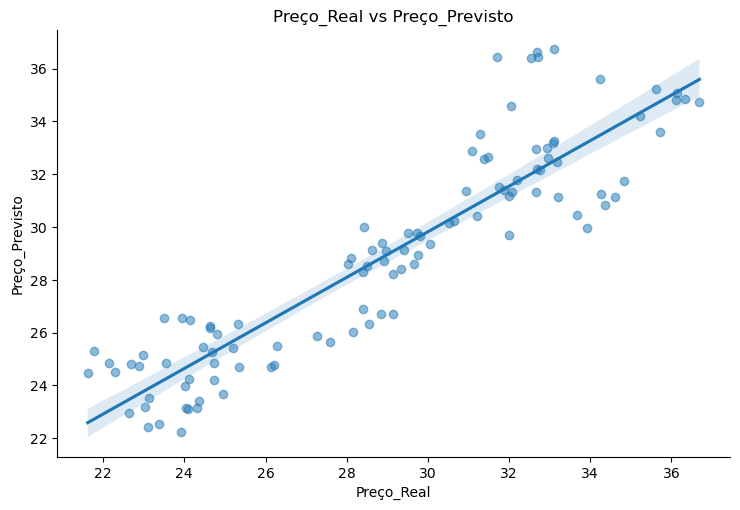

In [54]:
# Plota gráfico de dispersão com linha de regressão (fit_reg)
sns.lmplot(x='Preço_Real', y='Preço_Previsto', data=compare_df, aspect=1.5, fit_reg=True, scatter_kws={'alpha':0.5})

# Define os rótulos dos eixos e título
plt.xlabel("Preço_Real")
plt.ylabel("Preço_Previsto")
plt.title("Preço_Real vs Preço_Previsto")
plt.show()

Os pontos visivelmente se atraem próximos à linha de regressão indicando que as previsões do modelo são, na maior parte do tempo, consistentes com os valores reais.

Foi criado então um gráfico que comparou visualmente os preços reais (em vermelho) e os preços previstos (em azul) ao longo do tempo. Para aumentar a clareza da observação, foi adicionado um atraso (*lag*) no preço real de n dias de acordo com a variável days_before, essa sobreposição das linhas permite a análise direta da precisão do modelo em relação aos dados reais.

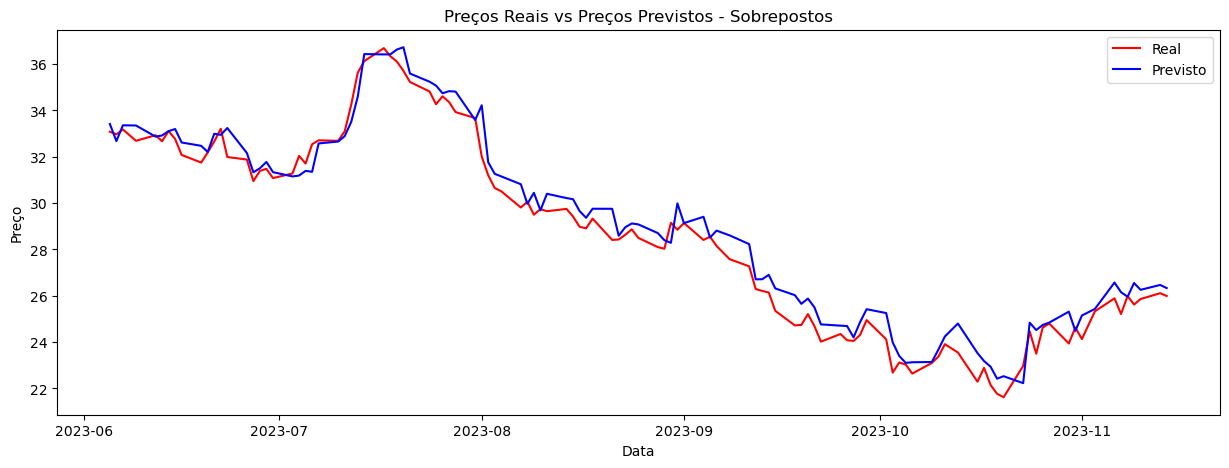

In [55]:
# Cria uma figura e um conjunto de subplots
fig, ax = plt.subplots(figsize=(15,5))

# Plota os valores reais e previstos
ax.plot_date(compare_df.index, compare_df.Preço_Real.shift(-days_before), 'r-', label='Real')
ax.plot_date(compare_df.index, compare_df.Preço_Previsto, 'b-', label='Previsto')

# Define os rótulos, título e legenda
ax.set_xlabel('Data')
ax.set_ylabel('Preço')
ax.set_title('Preços Reais vs Preços Previstos - Sobrepostos')
ax.legend()

plt.show()

No gráfico apresentado, observa-se que o modelo consegue estimar com precisão os valores reais. É importante destacar que tanto os valores máximos quanto os mínimos não ultrapassam os valores reais, garantindo assim a segurança do investidor. Vale ressaltar que, apesar do gráfico estar sobreposto, os valores previstos foram calculados com n dias de antecedência, conforme estabelecido durante a preparação dos dados.

Para finalizar nossa visualização, foi plotado um gráfico com ambas as linhas de acordo com suas datas reais, note que os valores previstos indicam com precisão quais às tendências que sucederam no decorrer dos dias. Por exemplo: Note que durante a alta nos valores a partir da metade do mês 2023-07, a previsão já indicava uma possível correção ou reversão, sendo confirmado com os valores reais se desvalorizando pouco antes do início de 2023-08.

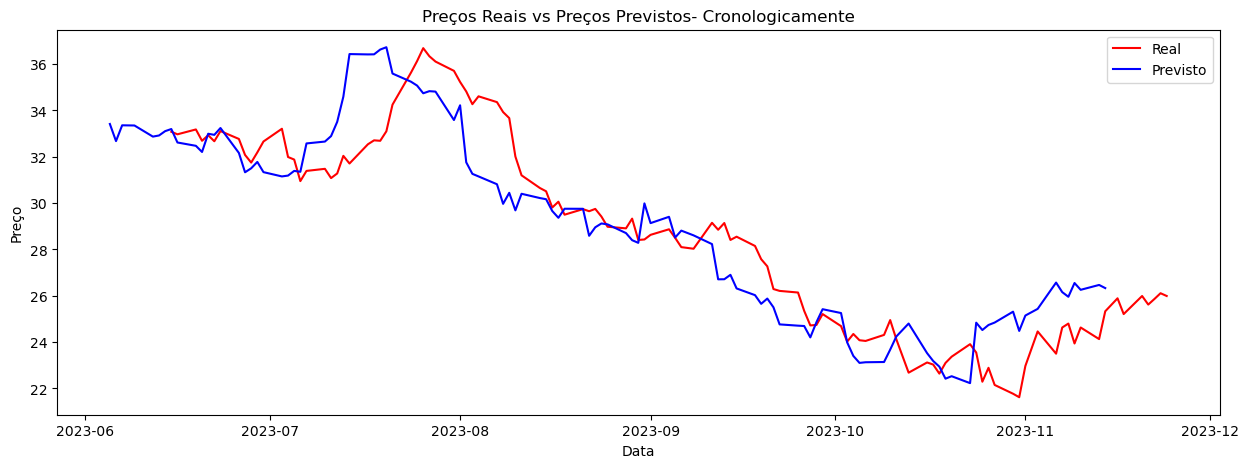

In [56]:
# Cria uma figura e um conjunto de subplots
fig, ax = plt.subplots(figsize=(15,5))

# Plota os dados reais
ax.plot_date(compare_df.index, compare_df.Preço_Real, 'r-', label='Real')

# Plota os dados previstos
ax.plot_date(compare_df.index, compare_df.Preço_Previsto, 'b-', label='Previsto')

# Define os rótulos, título e legenda
ax.set_xlabel('Data')
ax.set_ylabel('Preço')
ax.set_title('Preços Reais vs Preços Previstos- Cronologicamente')
ax.legend()

plt.show()

## Conclusão

Neste projeto, realizou-se a extração, transformação e carregamento (*ETL*) dos dados financeiros do setor de saúde por meio de da API *yFinance*, seguida pela análise e verificação da correlação entre as variáveis extraídas. Foram desenvolvidas duas classes organizadas, a "DataPreparation" para preparação dos dados, convertendo o dataframe original em um formato adequado para análise e modelagem, selecionando features, aplicando operações desejadas e criando colunas com valores de dias anteriores e a segunda classe, "ModelTraining," criada para treinar e predizer dados, utilizando o método "train_and_predict()." 
Foram empregadas métricas como Erro Médio Absoluto (MAE), Erro Quadrático Médio (MSE) e Validação Cruzada (CV) para avaliar o desempenho do modelo, e os resultados foram armazenados no dataframe "metrics_df." A análise desses resultados indicou um desempenho satisfatório do modelo, com consistência em diferentes subconjuntos de dados. Gráficos foram gerados para visualizar a precisão das previsões ao longo do tempo, identificando tendências e padrões nos dados. Em resumo, o projeto abrangeu extração, preparação, treinamento e avaliação de um modelo de regressão linear, cujas previsões foram consideradas relativamente satisfatórias e consistentes.

### Recomendações

Este notebook tem como objetivo fornecer uma análise didática de dados financeiros e não deve ser interpretado como uma recomendação para investir em qualquer ativo específico. As conclusões e resultados apresentados são apenas para fins educacionais. Os métodos apresentados aqui são simplistas, para uma predição robusta é preciso levar em consideração outros fatores e aplicar métodos diferentes como:

#### Análise Técnica
A análise técnica no mercado de ações utiliza gráficos, padrões e indicadores para prever movimentos futuros com base em dados históricos de preços e volumes. Ela se concentra em identificar tendências, suportes e resistências, além de usar indicadores matemáticos para orientar decisões de compra ou venda. O conceito pode ser facilmente incorporado neste projeto por se fazer uso de médias móveis, fibonacci, IFR entre outros. 

*fonte: https://conteudos.xpi.com.br/aprenda-a-investir/relatorios/o-que-e-analise-tecnica/*

#### Análise Fundamentalista
A análise fundamentalista é um método de avaliação de ativos que se concentra na situação financeira, econômica e setorial de uma empresa. Ela busca determinar o valor intrínseco de uma ação, levando em consideração fatores como patrimônio, lucro e receita da empresa. 

*fonte: https://conteudos.xpi.com.br/aprenda-a-investir/relatorios/analise-fundamentalista/*

#### Análise de Sentimento
A Análise de Sentimento utiliza processamento de linguagem natural avançado para determinar se os dados textuais fornecidos são positivos, negativos ou neutros. Esse tipo de análise pode ser aplicado a grandes conjuntos de dados textuais, como avaliações de clientes, teses de pesquisa, papers científicos, etc. Em um contexto específico, pode ser utilizado para analisar contas de redes sociais, como o Twitter, ou avaliações no Facebook de uma empresa. Pode também ser implementada em um projeto paralelo que alimente este modelo de predição com as informações extraídas. 

*fonte: https://repositorium.sdum.uminho.pt/bitstream/1822/73511/2/2021_Melhado_Rabot_Analise-de-sentimentos.pdf*

---



👉 Este projeto foi desenvolvido por *[Fernando Carneiro](https://www.linkedin.com/in/fernandohcarneiro/)*, conecte-se comigo!  <a href="https://www.linkedin.com/in/fernandohcarneiro/" target="_blank"><a title="LinkedIn, Public domain, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:LinkedIn_logo_initials.png"><img width="24" alt="LinkedIn logo initials" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/LinkedIn_logo_initials.png/64px-LinkedIn_logo_initials.png"></a> 
